# HPC Final Project: Stock Market Price Prediction with GPU Acceleration and Multi-Worker Strategy
## Done by: Zaid Alsaheb, Sofia Vitorica, Sebastian Perilla, Laura Cuellar,Ismael Picazzo

# Importing Packages and Setting up AWS S3 Bucket

In [1]:
# Install required packages
!pip install boto3
!pip install pycuda

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 22.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.3/89.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.0 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2024.1.2-cp310-cp310-linux_x86_64.whl size=660545 sha256=a90eb4ddf35691778082032ae91bdd05cadbe5e73a52287fb5c74fa4fd254972
  Stored in directory: /root/.cache/pip/wheels/70/63/40/4bf006182f942d3516b71bb2ff3b57ccbdb8b2c0ee81882b6e
Successfully built pycuda


In [2]:
import os
import boto3


aws_access_key_id = 'xxxx'
aws_secret_access_key = 'xxxx'
aws_region = 'eu-west-1'
s3_bucket_name = 'myhpcbucket-160903'


# Initialize S3 client
s3_client = boto3.client(
    's3',
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    region_name=aws_region
)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as data
import yfinance as yf
import tensorflow as tf
import time
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import boto3

# Data Collection and Exploration

In [4]:
ticker = "GOOGL"  # Google stock symbol
start_date = "2010-01-01"
end_date = "2024-01-01"
df = yf.download(ticker, start=start_date, end=end_date)
df = df.reset_index()
df = df.drop(['Date', 'Adj Close'], axis=1)
df.shape


[*********************100%***********************]  1 of 1 completed
<ipython-input-4-a4e9049303ba>:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df = df.drop(['Date', 'Adj Close'], axis=1)


(3522, 5)

In [5]:
df.shape

(3522, 5)

In [6]:
ma100 = df.Close.rolling(100).mean()

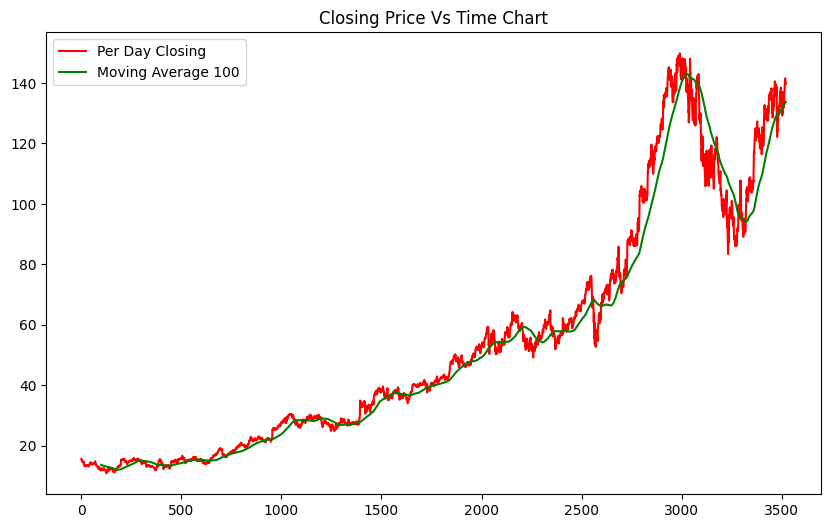

In [7]:
plt.figure(figsize = (10, 6))
plt.title("Closing Price Vs Time Chart")
plt.plot(df.Close, 'r', label="Per Day Closing")
plt.plot(ma100, 'g', label="Moving Average 100")
plt.legend()

In [8]:
ma200 = df.Close.rolling(200).mean()

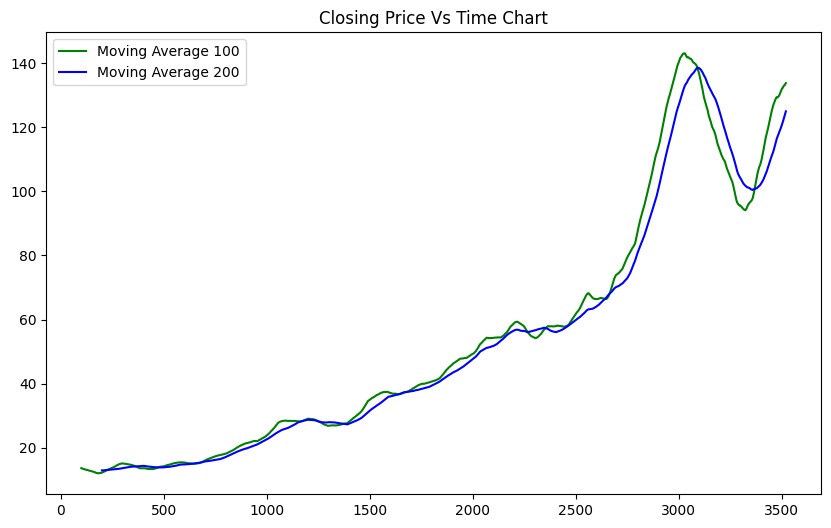

In [9]:
plt.figure(figsize = (10, 6))
plt.title("Closing Price Vs Time Chart")
plt.plot(ma100, 'g', label="Moving Average 100")
plt.plot(ma200, 'b', label="Moving Average 200")
plt.legend()

In [23]:
train_df = pd.DataFrame(df['Close'][0: int(len(df)*0.80)])
test_df = pd.DataFrame(df['Close'][int(len(df)*0.80):int(len(df))])
print(train_df.shape)
print(test_df.shape)

(2817, 1)
(705, 1)


# Data Preprocessing with Custom Kernel for Min-Max Scaling
Faster and scales in parallel

In [24]:
# Define the CUDA kernel
cuda_minmax_kernel = """
__global__ void min_max_scaler(float *data, float *min_vals, float *max_vals, int rows, int cols) {
    int idx = threadIdx.x + blockIdx.x * blockDim.x;
    int col = idx % cols;
    int row = idx / cols;

    if (row < rows && col < cols) {
        float min_val = min_vals[col];
        float max_val = max_vals[col];
        data[idx] = (data[idx] - min_val) / (max_val - min_val);
    }
}
"""

mod = SourceModule(cuda_minmax_kernel)
min_max_scaler = mod.get_function("min_max_scaler")

# Get rows and cols
train_df1 = train_df.to_numpy().astype(np.float32)
rows, cols = train_df1.shape

# Calculate min and max values per column on the CPU
min_vals = train_df1.min(axis=0).astype(np.float32)
max_vals = train_df1.max(axis=0).astype(np.float32)

# Allocate GPU memory and transfer data
train_df_gpu = cuda.mem_alloc(train_df1.nbytes)
cuda.memcpy_htod(train_df_gpu, train_df1)
min_vals_gpu = cuda.mem_alloc(min_vals.nbytes)
cuda.memcpy_htod(min_vals_gpu, min_vals)
max_vals_gpu = cuda.mem_alloc(max_vals.nbytes)
cuda.memcpy_htod(max_vals_gpu, max_vals)

# Launch kernel
threads_per_block = 256
blocks_per_grid = (rows * cols + threads_per_block - 1) // threads_per_block
min_max_scaler(train_df_gpu, min_vals_gpu, max_vals_gpu, np.int32(rows), np.int32(cols),
               block=(threads_per_block, 1, 1), grid=(blocks_per_grid, 1))

# Copy back the scaled data
train_df_arr = np.empty_like(train_df1)
cuda.memcpy_dtoh(train_df_arr, train_df_gpu)

print("Scaled Data (NumPy Array):")
print(train_df_arr)

Scaled Data (NumPy Array):
[[0.05021947]
 [0.04949257]
 [0.04534975]
 ...
 [0.9566242 ]
 [0.990486  ]
 [0.9638912 ]]


In [25]:
# 80/20 train/test split
x_train = []
y_train = []
for i in range(100, train_df_arr.shape[0]):
    x_train.append(train_df_arr[i-100: i])
    y_train.append(train_df_arr[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape, y_train.shape

((2717, 100, 1), (2717,))

# Model Building

In [26]:
# Defining our LSTM
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

model = Sequential()

model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=60, activation='relu', return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80, activation='relu', return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=120, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))

In [27]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 100, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 100, 50)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 100, 60)             │          26,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 100, 60)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 100, 80)             │          45,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 100, 80)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 120)                 │          96,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 178,761 (698.29 KB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

# GPU Mean Squared Error Calculation

In [28]:
# CUDA Kernel for Mean Squared Error Computation
cuda_mse_kernel = """
__global__ void compute_mse(float *predictions, float *true_values, float *mse, int n) {
    __shared__ float partial_sum[256];
    int tid = threadIdx.x;
    int i = blockIdx.x * blockDim.x + threadIdx.x;

    float error = 0.0f;
    if (i < n) {
        error = predictions[i] - true_values[i];
        error = error * error;
    }

    // Parallel reduction in shared memory
    partial_sum[tid] = error;
    __syncthreads();

    for (int stride = blockDim.x/2; stride > 0; stride >>= 1) {
        if (tid < stride) {
            partial_sum[tid] += partial_sum[tid + stride];
        }
        __syncthreads();
    }

    // First thread writes the block's result
    if (tid == 0) {
        atomicAdd(mse, partial_sum[0] / n);
    }
}
"""

class PyCUDAMSEComputer:
    def __init__(self, block_size=256):
        """
        Initialize PyCUDA MSE Computer

        Args:
            block_size (int): CUDA block size for parallel computation
        """
        self.block_size = block_size

        # Compile CUDA kernel
        self.mod = SourceModule(cuda_mse_kernel)
        self.compute_mse_kernel = self.mod.get_function("compute_mse")

    def compute_mse_gpu(self, predictions, true_values):
        """
        Compute Mean Squared Error using GPU

        Args:
            predictions (np.ndarray): Model predictions
            true_values (np.ndarray): True target values

        Returns:
            float: Mean Squared Error
        """
        # Flatten predictions and true_values to 1D array
        predictions_flat = predictions.flatten().astype(np.float32)
        true_values_flat = true_values.flatten().astype(np.float32)

        # Check input compatibility
        assert predictions_flat.shape == true_values_flat.shape, "Flattened predictions and true values must have same shape"

        # Prepare GPU memory
        n = len(predictions_flat)
        grid_size = (n + self.block_size - 1) // self.block_size

        # Allocate GPU memory
        predictions_gpu = cuda.mem_alloc(predictions_flat.nbytes)
        true_values_gpu = cuda.mem_alloc(true_values_flat.nbytes)
        mse_gpu = cuda.mem_alloc(4)  # float size

        # Copy data to GPU
        cuda.memcpy_htod(predictions_gpu, predictions_flat)
        cuda.memcpy_htod(true_values_gpu, true_values_flat)

        # Initialize MSE to zero
        mse = np.zeros(1, dtype=np.float32)
        cuda.memcpy_htod(mse_gpu, mse)

        # Call CUDA kernel
        self.compute_mse_kernel(
            predictions_gpu, true_values_gpu, mse_gpu, np.int32(n),
            block=(self.block_size, 1, 1),
            grid=(grid_size, 1)
        )

        # Copy result back to host
        cuda.memcpy_dtoh(mse, mse_gpu)

        return mse[0]

# GPU Averaging Model Weights

In [40]:
import numpy as np
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import tensorflow as tf

def average_models_weighted_gpu(current_model, other_models, other_mses, current_model_mse):
    """
    Averages the current model with other models using weights based on MSE, utilizing a custom CUDA kernel.

    This function combines the CUDA kernel definition, compilation, and execution into a single function for ease of use.

    Args:
        current_model (tf.keras.Model): The current worker's model.
        other_models (list of tf.keras.Model): Models from other workers.
        other_mses (list of float): Corresponding MSEs of the other models.
        current_model_mse (float): MSE of the current model.

    Returns:
        None. The function updates the current_model's weights in place.
    """

    # Define the CUDA kernel within the function
    cuda_weighted_average_kernel = """
    extern "C" {
__global__ void weighted_average_weights(
    float* input,      // Flattened input weights from all models
    float* weights,    // Weights based on inverse MSE
    float* output,     // Output averaged weights
    int num_models,    // Number of models
    int num_elements   // Number of elements in each weight array
) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < num_elements) {
        float sum = 0.0f;
        for (int m = 0; m < num_models; ++m) {
            sum += input[m * num_elements + idx] * weights[m];
        }
        output[idx] = sum;
    }
}
}
    """

    # Compile the CUDA kernel
    mod = SourceModule(cuda_weighted_average_kernel)

    # Get the kernel launch function
    weighted_average_kernel = mod.get_function("weighted_average_weights")

    # Validate inputs
    if len(other_models) != len(other_mses):
        raise ValueError("Number of other_models must match number of other_mses.")

    # Compute weights: inverse of MSE
    try:
        inverse_mses = [1.0 / mse for mse in other_mses]
        inverse_mses.append(1.0 / current_model_mse)
    except ZeroDivisionError:
        raise ValueError("One of the MSE values is zero, which is invalid for weight computation.")

    # Normalize weights so that they sum to 1
    total_inverse = sum(inverse_mses)
    if total_inverse == 0:
        raise ValueError("Sum of inverse MSEs is zero, cannot normalize weights.")
    weights = [inv_mse / total_inverse for inv_mse in inverse_mses]

    # Get weights from all models (current + others)
    models = [current_model] + other_models
    all_weights = [model.get_weights() for model in models]

    # Initialize list to hold averaged weights
    averaged_weights = []

    # Iterate over each layer's weights
    for weights_list_tuple in zip(*all_weights):
        # Convert each weight array to float32
        weight_arrays = [w.astype(np.float32) for w in weights_list_tuple]

        # Stack and flatten the weight arrays
        # Each model's weights are stacked sequentially
        stacked_weights = np.stack(weight_arrays, axis=0).flatten().astype(np.float32)

        num_models = len(models)
        num_elements = stacked_weights.size // num_models

        # Allocate GPU memory for input, weights, and output
        d_input = cuda.mem_alloc(stacked_weights.nbytes)
        d_weights = cuda.mem_alloc(np.array(weights, dtype=np.float32).nbytes)
        d_output = cuda.mem_alloc(num_elements * 4)  # float32 has 4 bytes

        # Copy data to GPU
        cuda.memcpy_htod(d_input, stacked_weights)
        cuda.memcpy_htod(d_weights, np.array(weights, dtype=np.float32))

        # Launch the CUDA kernel
        weighted_average_kernel(
            d_input,
            d_weights,
            d_output,
            np.int32(num_models),
            np.int32(num_elements),
            block=(256, 1, 1),
            grid=((num_elements + 255) // 256, 1)
        )

        # Create an empty array to receive the output
        averaged_flat = np.empty(num_elements, dtype=np.float32)

        # Copy the averaged weights back to CPU
        cuda.memcpy_dtoh(averaged_flat, d_output)

        # Reshape to original weight shape
        averaged_weight = averaged_flat.reshape(weight_arrays[0].shape)

        # Append to averaged_weights list
        averaged_weights.append(averaged_weight)

        # Free GPU memory
        d_input.free()
        d_weights.free()
        d_output.free()

    # Set the averaged weights to the primary model
    current_model.set_weights(averaged_weights)
    print("Model weights averaged using custom CUDA kernel.")
    return


# Functions to Synchronize Workers Using Shared Storage (AWS S3)

In [47]:
def save_model_to_s3(model, s3_client, bucket_name, model_key):
    """
    Save model to S3 with improved error handling

    Args:
        model (tf.keras.Model): Model to save
        s3_client (boto3.client): S3 client
        bucket_name (str): S3 bucket name
        model_key (str): S3 object key
    """
    try:
        # Save model in newer Keras format
        local_path = 'local_model.keras'
        model.save(local_path)

        # Upload to S3
        try:
            s3_client.upload_file(local_path, bucket_name, model_key)
            print(f"Model saved to S3 bucket '{bucket_name}' with key '{model_key}'.")
        except Exception as upload_error:
            print(f"S3 Upload Error: {upload_error}")
            print("Credentials or permissions might be incorrect.")

            # Additional debugging information
            try:
                # Check bucket existence
                s3_client.head_bucket(Bucket=bucket_name)
                print(f"Bucket {bucket_name} exists.")
            except Exception as bucket_error:
                print(f"Bucket access error: {bucket_error}")

            # List buckets to verify credentials
            try:
                buckets = s3_client.list_buckets()
                print("Available buckets:")
                for bucket in buckets['Buckets']:
                    print(f"- {bucket['Name']}")
            except Exception as list_error:
                print(f"Error listing buckets: {list_error}")

    except Exception as save_error:
        print(f"Model save error: {save_error}")


In [46]:
def load_model_from_s3(s3_client, bucket_name, model_key):
    """
    Load model from S3 with improved error handling

    Args:
        s3_client (boto3.client): S3 client
        bucket_name (str): S3 bucket name
        model_key (str): S3 object key

    Returns:
        tf.keras.Model: Loaded model
    """
    try:
        local_path = 'downloaded_model.keras'

        # Download with explicit error handling
        try:
            s3_client.download_file(bucket_name, model_key, local_path)
        except Exception as download_error:
            print(f"S3 Download Error: {download_error}")
            print("Check if the object key is correct and you have read permissions.")
            raise

        # Load model
        model = tf.keras.models.load_model(local_path)
        print(f"Model loaded from S3 bucket '{bucket_name}' with key '{model_key}'.")
        return model

    except Exception as load_error:
        print(f"Model load error: {load_error}")
        raise


In [45]:
def verify_s3_credentials(s3_client):
    """
    Verify AWS S3 credentials and access

    Args:
        s3_client (boto3.client): S3 client

    Returns:
        bool: True if credentials are valid, False otherwise
    """
    try:
        # List buckets to verify credentials
        buckets = s3_client.list_buckets()
        print("S3 Credentials Verified. Available buckets:")
        for bucket in buckets['Buckets']:
            print(f"- {bucket['Name']}")
        return True
    except Exception as e:
        print(f"Credential Verification Failed: {e}")
        return False

In [32]:
def save_mse_to_s3(s3_client, bucket_name, mse_key, mse_value):
    """
    Saves the MSE value to S3.

    Args:
        s3_client (boto3.client): Initialized S3 client.
        bucket_name (str): Name of the S3 bucket.
        mse_key (str): S3 object key for the MSE value.
        mse_value (float): The MSE value to save.
    """
    try:
        with open('temp_mse.txt', 'w') as f:
            f.write(str(mse_value))
        s3_client.upload_file('temp_mse.txt', bucket_name, mse_key)
        print(f"MSE saved to S3 as {mse_key}.")
    except Exception as e:
        print(f"Error saving MSE to S3: {e}")


In [33]:
def load_mse_from_s3(s3_client, bucket_name, mse_key):
    """
    Loads the MSE value from S3.

    Args:
        s3_client (boto3.client): Initialized S3 client.
        bucket_name (str): Name of the S3 bucket.
        mse_key (str): S3 object key for the MSE value.

    Returns:
        float: The loaded MSE value.
    """
    try:
        s3_client.download_file(bucket_name, mse_key, 'temp_other_mse.txt')
        with open('temp_other_mse.txt', 'r') as f:
            mse = float(f.read())
        print(f"MSE {mse_key} loaded from S3.")
        return mse
    except Exception as e:
        print(f"Error loading MSE from S3: {e}")
        raise


In [34]:
def check_model_architecture(models):
    """
    Checks if all models have the same architecture.

    Args:
        models (list of tf.keras.Model): List of models to check.

    Raises:
        ValueError: If any model has a different architecture.
    """
    base_config = models[0].get_config()
    for model in models[1:]:
        if model.get_config() != base_config:
            raise ValueError("All models must have the same architecture for synchronization.")


# Callback to Synchronize Workers Every 5 Epochs

In [37]:
import tensorflow as tf

class PyCUDASynchronizationCallback(tf.keras.callbacks.Callback):
    def __init__(self,
                 worker_id,
                 s3_client,
                 bucket_name,
                 sync_epochs=5,
                 mse_computer=None):
        """
        Initialize synchronization callback with S3 integration and GPU acceleration.

        Args:
            worker_id (str): Unique identifier for the worker.
            s3_client (boto3.client): Initialized S3 client.
            bucket_name (str): Name of the S3 bucket.
            sync_epochs (int): Frequency of synchronization in epochs.
            mse_computer (PyCUDAMSEComputer): Optional custom MSE computer.
        """
        super(PyCUDASynchronizationCallback, self).__init__()
        self.worker_id = worker_id
        self.s3_client = s3_client
        self.bucket_name = bucket_name
        self.sync_epochs = sync_epochs
        self.mse_computer = mse_computer or PyCUDAMSEComputer()

    def on_epoch_end(self, epoch, logs=None):
        """
        Callback method for epoch end with S3 synchronization.

        Args:
            epoch (int): Current training epoch.
            logs (dict): Logs from the training process.
        """
        if (epoch + 1) % self.sync_epochs != 0:
            return

        print(f"\nEpoch {epoch+1}: Starting model synchronization.")

        try:
            # Predict on training data
            predictions = self.model.predict(x_train)

            # Compute GPU-accelerated MSE
            gpu_mse = self.mse_computer.compute_mse_gpu(predictions, y_train)
            print(f"GPU-Accelerated MSE at epoch {epoch+1}: {gpu_mse}")

            # Save current model to S3
            model_key = f"model_checkpoints/{self.worker_id}_epoch_{epoch+1}.keras"
            save_model_to_s3(self.model, self.s3_client, self.bucket_name, model_key)

            # Save MSE to S3
            mse_key = f"model_checkpoints/{self.worker_id}_epoch_{epoch+1}_mse.txt"
            save_mse_to_s3(self.s3_client, self.bucket_name, mse_key, gpu_mse)

            # Retrieve other models and their MSEs from S3
            response = self.s3_client.list_objects_v2(
                Bucket=self.bucket_name,
                Prefix='model_checkpoints/'
            )

            if 'Contents' not in response:
                print("No models found in the specified S3 bucket.")
                return

            other_model_keys = []
            other_mse_keys = []
            for obj in response.get('Contents', []):
                key = obj['Key']
                # Exclude current worker's models and averaged models
                if self.worker_id not in key and "averaged" not in key and f"epoch_{epoch+1}.keras" in key:
                    other_model_keys.append(key)
                if key.endswith(f'{epoch+1}_mse.txt'):
                      other_mse_keys.append(key)

            other_models = []
            other_mses = []
            for model_key, mse_key in zip(other_model_keys, other_mse_keys):
                # Load the model
                other_model = load_model_from_s3(
                    self.s3_client,
                    self.bucket_name,
                    model_key
                )
                other_models.append(other_model)

                # Load the MSE
                other_mse = load_mse_from_s3(
                    self.s3_client,
                    self.bucket_name,
                    mse_key
                )
                other_mses.append(other_mse)

            # Current model's MSE
            current_model_mse = gpu_mse

            if other_models:

                # Perform weighted averaging using GPU
                average_models_weighted_gpu(
                    current_model=self.model,
                    other_models=other_models,
                    other_mses=other_mses,
                    current_model_mse=current_model_mse
                )

                # Save averaged model to S3
                averaged_model_key = f"model_checkpoints/averaged_epoch_{epoch+1}.keras"
                save_model_to_s3(self.model, self.s3_client, self.bucket_name, averaged_model_key)
                print(f"Models synchronized and averaged at epoch {epoch+1}.")
            else:
                print("No other models found for synchronization.")

        except Exception as sync_error:
            print(f"Synchronization error at epoch {epoch+1}: {sync_error}")


# Training the Model

In [41]:
def main():
    # Verify S3 credentials before proceeding
    if not verify_s3_credentials(s3_client):
        print("Cannot proceed with training due to credential issues.")
        return

    # Initialize PyCUDA MSE Computer
    mse_computer = PyCUDAMSEComputer()

    # Assign worker ID
    worker_id = 'worker_2'

    # Create synchronization callback
    sync_callback = PyCUDASynchronizationCallback(
        worker_id,
        s3_client,
        s3_bucket_name,
        sync_epochs=5,
        mse_computer=mse_computer
    )

    # Compile and train model
    model.compile(loss='mean_squared_error', optimizer='adam')
    start_time = time.time()

    model.fit(
        x_train, y_train,
        epochs=50,
        batch_size=32,
        callbacks=[sync_callback]
    )

    end_time = time.time()

    elapsed_time = end_time - start_time

    print(f"Training completed in {elapsed_time:.2f} seconds.")

main()

S3 Credentials Verified. Available buckets:
- aws-cloudtrail-logs-657762149587-de790a22
- aws-cloudtrail-logs-657762149587-fc1656ec
- myhpcbucket-160903
Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 17s 95ms/step - loss: 0.0033
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0023
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0023
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0025
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0020
Epoch 5: Starting model synchronization.
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 242ms/step
GPU-Accelerated MSE at epoch 5: 0.000659699784591794
Model saved to S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_1_epoch_5.keras'.
MSE saved to S3 as model_checkpoints/worker_1_epoch_5_mse.txt.
Model loaded from S3 bucket 'myhpcbucket-160903' with key 'model_checkpoints/worker_0_epoch_5.keras'.
MSE model_checkpoints/worker_0_epoch_15_mse.txt loaded from S3.
Model weights averaged using custom CUDA kernel.
Mod

In [ ]:
model.save('keras_model.h5')

# Testing the Model

In [42]:
past_100_days = train_df.tail(100)
final_df = past_100_days._append(test_df, ignore_index=True)
final_df.head()

Ticker,GOOGL
0,76.497498
1,77.554001
2,79.299500
3,80.333000
4,81.649002


In [43]:
# Scaling the prediction data

# Define the CUDA kernel
cuda_minmax_kernel = """
__global__ void min_max_scaler(float *data, float *min_vals, float *max_vals, int rows, int cols) {
    int idx = threadIdx.x + blockIdx.x * blockDim.x;
    int col = idx % cols;
    int row = idx / cols;

    if (row < rows && col < cols) {
        float min_val = min_vals[col];
        float max_val = max_vals[col];
        data[idx] = (data[idx] - min_val) / (max_val - min_val);
    }
}
"""

mod = SourceModule(cuda_minmax_kernel)
min_max_scaler = mod.get_function("min_max_scaler")
# Assuming final_df is a Pandas DataFrame
final_df_arr = final_df.to_numpy().astype(np.float32)  # Convert to NumPy array
rows, cols = final_df_arr.shape

# Calculate min and max values per column for final_df
min_vals_final = final_df_arr.min(axis=0).astype(np.float32)
max_vals_final = final_df_arr.max(axis=0).astype(np.float32)

# Allocate GPU memory and transfer data
final_df_gpu = cuda.mem_alloc(final_df_arr.nbytes)
cuda.memcpy_htod(final_df_gpu, final_df_arr)

min_vals_final_gpu = cuda.mem_alloc(min_vals_final.nbytes)
cuda.memcpy_htod(min_vals_final_gpu, min_vals_final)

max_vals_final_gpu = cuda.mem_alloc(max_vals_final.nbytes)
cuda.memcpy_htod(max_vals_final_gpu, max_vals_final)

# Launch the CUDA kernel
threads_per_block = 256
blocks_per_grid = (rows * cols + threads_per_block - 1) // threads_per_block
min_max_scaler(final_df_gpu, min_vals_final_gpu, max_vals_final_gpu, np.int32(rows), np.int32(cols),
               block=(threads_per_block, 1, 1), grid=(blocks_per_grid, 1))

# Copy back the scaled data
final_df_scaled = np.empty_like(final_df_arr)
cuda.memcpy_dtoh(final_df_scaled, final_df_gpu)

# `final_df_scaled` is now a scaled NumPy array
input_data = final_df_scaled  # Keep as NumPy array

# Display the first few rows of the scaled array
print("Scaled data (array):")
print(input_data[:5])  # Print the first 5 rows
print("Input data shape:", input_data.shape)


Scaled data (array):
[[0.01288716]
 [0.02710687]
 [0.05059993]
 [0.06451004]
 [0.0822224 ]]
Input data shape: (805, 1)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


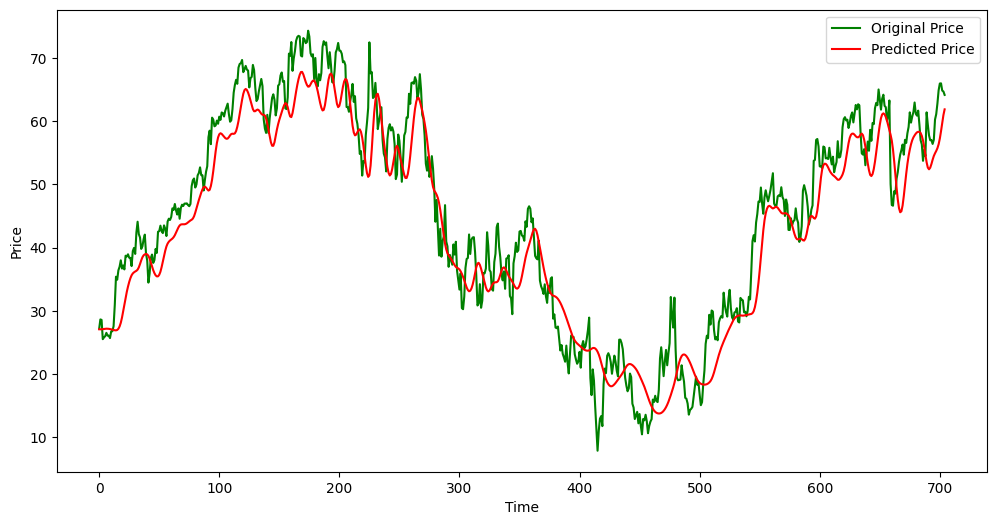

In [44]:
x_test = []
y_test = []
for i in range(100, input_data.shape[0]):
    x_test.append(input_data[i-100: i])
    y_test.append(input_data[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test.shape, y_test.shape
y_pred = model.predict(x_test)

final_df_arr = final_df.to_numpy().astype(np.float32)
rows, cols = final_df_arr.shape

# Calculate min and max values per column for final_df
min_vals_final = final_df_arr.min(axis=0).astype(np.float32)
max_vals_final = final_df_arr.max(axis=0).astype(np.float32)

# Calculate the scale values for each feature
scale = 1.0 / (max_vals_final - min_vals_final)
scale_factor = 1/scale
y_pred = y_pred*scale_factor
y_test = y_test*scale_factor


plt.figure(figsize=(12, 6))
plt.plot(y_test, 'g', label="Original Price")
plt.plot(y_pred, 'r', label="Predicted Price")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()